In [1]:
%cd ..

G:\operation d\active project\const_hw


In [2]:
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline
from src._helper_class import *
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, PoissonRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVC, SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, average_precision_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load data
train_data = pd.read_csv("data/dengue_features_train.csv")
train_label = pd.read_csv("data/dengue_labels_train.csv")
test_data = pd.read_csv("data/dengue_features_test.csv")

In [4]:
# classification pipeline
clf_scoring = 'average_precision'

clf_pipeline = imblearn_make_pipeline(
    Dengue_cat_encoder(),
    Stationarity_adjustment(),
    Feature_argumentation1(),
    Standardization(),
    Imputer(),
    Feature_argumentation2(),
    Feature_argumentation3(),
    Feature_selection(cv_metric = clf_scoring,
                      classify_mode = 1),
    General_estimator()
)

clf_parameters = [
    {"general_estimator__estimator": [XGBClassifier(grow_policy = "lossguide",
                                                   objective = "binary:logistic",
                                                   booster = "gbtree",
                                                   tree_method = "hist",
                                                   eta = 0.1
                                                   )
                                     ],
     "general_estimator__estimator__n_estimators": [5, 8, 11, 14, 17],
     "general_estimator__estimator__scale_pos_weight": [1],
     "general_estimator__estimator__max_leaves": [3, 5, 7, 9],
     "general_estimator__estimator__min_child_weight": [1],
     "general_estimator__estimator__subsample": [1],
     "feature_selection__estimator": [XGBClassifier(objective = "binary:logistic",
                                                   booster = "gbtree",
                                                   tree_method = "hist")
                                     ]
    },
    
    {"general_estimator__estimator": [LogisticRegression()],
     "general_estimator__estimator__class_weight": ["balanced"],
     "feature_selection__estimator": [LogisticRegression()]
    },
    
    {"general_estimator__estimator": [SVC(kernel = 'rbf',
                                          max_iter = 10000)
                                     ],
     "general_estimator__estimator__class_weight": ["balanced"],
     "general_estimator__estimator__C": [1e-1, 1e0, 1e1, 1e2, 1e3],
     "feature_selection__estimator": [SVC(kernel = 'rbf',
                                          max_iter = 10000)
                                     ]
    }

]


# regression pipeline

reg_scoring = "neg_mean_absolute_error"

reg_pipeline = imblearn_make_pipeline(
    Dengue_cat_encoder(),
    Stationarity_adjustment(),
    Feature_argumentation1(),
    Standardization(),
    Imputer(),
    Feature_argumentation2(),
    Feature_argumentation3(),
    Feature_selection(),
    General_estimator()
)

reg_parameters = [
    {"general_estimator__estimator": [XGBRegressor(grow_policy = "lossguide",
                                                   objective = "reg:squarederror",
                                                   booster = "gbtree",
                                                   tree_method = "hist",
                                                   eta = 0.1
                                                   )
                                     ],
     "general_estimator__estimator__n_estimators": [5, 8, 11, 14, 17],
     "general_estimator__estimator__max_leaves": [3, 5, 7, 9],
     "general_estimator__estimator__min_child_weight": [1],
     "general_estimator__estimator__subsample": [1],
     "general_estimator__severity_mode": [1],
     "feature_selection__estimator": [XGBRegressor(objective = "reg:squarederror",
                                                   booster = "gbtree",
                                                   tree_method = "hist"
                                                   )
                                     ]
    },
    
    {"general_estimator__estimator": [PoissonRegressor(max_iter = 10000)],
     "general_estimator__estimator__alpha": [0.1],
     "general_estimator__severity_mode": [1],
     "feature_selection__estimator": [PoissonRegressor(max_iter = 10000)]
    },
    
    {"general_estimator__estimator": [SVR(kernel = 'rbf',
                                          max_iter = 10000)
                                     ],
     "general_estimator__estimator__C": [1e-1, 1e0, 1e1, 1e2, 1e3],
     "general_estimator__severity_mode": [1],
     "feature_selection__estimator": [SVR(kernel = 'rbf',
                                          max_iter = 10000)
                                     ]
    }

]


In [5]:
def perpensity_model_fit_transform(city, 
                                   threshold, 
                                   train_data, 
                                   train_label, 
                                   test_data, 
                                   model_scoring, 
                                   model_pipeline, 
                                   model_parameters):
    
    train_data = train_data.loc[train_data["city"] == city,:].copy()
    train_data.reset_index(drop = True, inplace = True)
    X = train_data.drop(columns = ["city"])
    
    Y = train_label.loc[train_label["city"] == city,:].copy()
    Y.reset_index(drop = True, inplace = True)
    Y = Y["total_cases"]
    Y = (Y >= threshold).astype(int)
    
    test_data = test_data.loc[test_data["city"] == city,:].copy()
    test_data.reset_index(drop = True, inplace = True)
    X_test = test_data.drop(columns = ["city"])
    
    model_parameters[0]["general_estimator__estimator__scale_pos_weight"] = [len(Y)/Y.sum()]

    model_gscv = GridSearchCV(estimator = model_pipeline, 
                              param_grid = model_parameters, 
                              scoring = model_scoring, 
                              cv = 5, 
                              verbose = 1,
                              n_jobs = -1,
                              return_train_score = True,
                              error_score = 0)
    
    model_gscv.fit(X, Y)
    
    #print("The select parameters:")
    #print(model_gscv.best_params_)
    
    pred_train = model_gscv.best_estimator_.predict_proba(X)[:,1]
    pred_test = model_gscv.best_estimator_.predict_proba(X_test)[:,1]
    
    print("baseline average precision: {}".format(sum(Y)/len(Y)))
    print("current average precision: {}".format(average_precision_score(Y, pred_train)))
    
    train_data["perpensity"] = pred_train
    test_data["perpensity"] = pred_test
    
    return train_data[["city", "week_start_date", "perpensity"]], test_data[["city", "week_start_date", "perpensity"]], model_gscv

def severity_model_fit_transform(city, 
                                 threshold, 
                                 train_data, 
                                 train_label, 
                                 test_data, 
                                 model_scoring, 
                                 model_pipeline, 
                                 model_parameters):
    
    train_data = train_data.loc[train_data["city"] == city,:].copy()
    train_data.reset_index(drop = True, inplace = True)
    X = train_data.drop(columns = ["city"])
    
    Y = train_label.loc[train_label["city"] == city,:].copy()
    Y.reset_index(drop = True, inplace = True)
    Y = Y["total_cases"]
    
    test_data = test_data.loc[test_data["city"] == city,:].copy()
    test_data.reset_index(drop = True, inplace = True)
    X_test = test_data.drop(columns = ["city"])
    
    for i in range(len(model_parameters)):
        model_parameters[0]["general_estimator__threshold"] = [threshold]
           
    model_gscv = GridSearchCV(estimator = model_pipeline, 
                              param_grid = model_parameters, 
                              scoring = model_scoring, 
                              cv = 5, 
                              verbose = 1,
                              n_jobs = -1,
                              return_train_score = True,
                              error_score = Y.mean()+ Y.std())
    

    
    model_gscv.fit(X, Y)
    
    #print("The select parameters:")
    #print(model_gscv.best_params_)
    
    pred_train = model_gscv.best_estimator_.predict(X)
    pred_test = model_gscv.best_estimator_.predict(X_test)
        
    train_data["severity"] = pred_train
    test_data["severity"] = pred_test
    
    return train_data[["city", "week_start_date", "severity"]], test_data[["city", "week_start_date", "severity"]], model_gscv

In [6]:
def two_stage_model_wraper(train_data, 
                           train_label, 
                           test_data, 
                           model_scoring_p, 
                           model_pipeline_p, 
                           model_parameters_p,
                           model_scoring_s, 
                           model_pipeline_s, 
                           model_parameters_s):
    best_score = np.inf
    
    threshold_list = [60, 90, 100]
    
    for threshold in threshold_list:
        print("Fitting SJ data with threshold {}".format(threshold))
        train_perpen_sj, test_perpen_sj, cv_perpen_sj = perpensity_model_fit_transform("sj",
                                                                              threshold,
                                                                              train_data, 
                                                                              train_label, 
                                                                              test_data, 
                                                                              model_scoring_p,
                                                                              model_pipeline_p,
                                                                              model_parameters_p)
        #print("fitting severity")
        train_sev_sj, test_sev_sj, cv_sev_sj = severity_model_fit_transform("sj",
                                                                            threshold,
                                                                            train_data, 
                                                                            train_label, 
                                                                            test_data, 
                                                                            model_scoring_s,
                                                                            model_pipeline_s,
                                                                            model_parameters_s)

        print("Fitting IQ data with threshold {}".format(threshold - 45))
        train_perpen_iq, test_perpen_iq, cv_perpen_iq = perpensity_model_fit_transform("iq",
                                                                              threshold - 45,
                                                                              train_data, 
                                                                              train_label, 
                                                                              test_data, 
                                                                              model_scoring_p,
                                                                              model_pipeline_p,
                                                                              model_parameters_p)
    

        #print("fitting severity")
        train_sev_iq, test_sev_iq, cv_sev_iq = severity_model_fit_transform("iq",
                                                                            threshold - 45,
                                                                            train_data, 
                                                                            train_label, 
                                                                            test_data, 
                                                                            model_scoring_s,
                                                                            model_pipeline_s,
                                                                            model_parameters_s)
        #-----------------------------------------
        temp_train_data = train_data.copy()
    
        train_perpen = pd.concat([train_perpen_sj, train_perpen_iq], ignore_index = True)
        train_sev = pd.concat([train_sev_sj, train_sev_iq], ignore_index = True)
                        
        temp_train_data = temp_train_data.merge(train_perpen, on = ["city", "week_start_date"], how = "left")
        temp_train_data = temp_train_data.merge(train_sev, on = ["city", "week_start_date"], how = "left")
        
        train_prediction = (temp_train_data["perpensity"] * temp_train_data["severity"]).to_numpy()
        train_prediction = train_prediction - train_prediction.mean() + train_label["total_cases"].mean()
        
        temp_train_data["prediction"] = train_prediction.astype(int)
        #----------------------------
        temp_test_data = test_data.copy()
        
        test_perpen = pd.concat([test_perpen_sj, test_perpen_iq], ignore_index = True)
        test_sev = pd.concat([test_sev_sj, test_sev_iq], ignore_index = True)
    
        temp_test_data = temp_test_data.merge(test_perpen, on = ["city", "week_start_date"], how = "left")
        temp_test_data = temp_test_data.merge(test_sev, on = ["city", "week_start_date"], how = "left")

        test_prediction = (temp_test_data["perpensity"] * temp_test_data["severity"]).to_numpy()
        test_prediction = test_prediction - test_prediction.mean() + train_label["total_cases"].mean()
        
        temp_test_data["prediction"] = test_prediction.astype(int)
    
        current_score = mean_absolute_error(train_label["total_cases"], temp_train_data["prediction"])
        
        if current_score < best_score:
            print("Perpensity selection threshold: {}".format(threshold))
            print("MAE: {}".format(current_score))
            out_train = temp_train_data
            out_test = temp_test_data
          
    out_train = out_train[["city", "year", "weekofyear", "week_start_date", "prediction"]]
    out_test = out_test[["city", "year", "weekofyear", "week_start_date", "prediction"]]
    
    return out_train, out_test

In [7]:
train_pred, test_pred = two_stage_model_wraper(train_data, 
                                               train_label, 
                                               test_data,
                                               clf_scoring,
                                               clf_pipeline,
                                               clf_parameters,
                                               reg_scoring, 
                                               reg_pipeline, 
                                               reg_parameters)

Fitting SJ data with threshold 60
Fitting 5 folds for each of 26 candidates, totalling 130 fits
baseline average precision: 0.14102564102564102
current average precision: 0.27644570723041473
Fitting 5 folds for each of 26 candidates, totalling 130 fits
Fitting IQ data with threshold 15
Fitting 5 folds for each of 26 candidates, totalling 130 fits
baseline average precision: 0.1423076923076923
current average precision: 0.4845325286080992
Fitting 5 folds for each of 26 candidates, totalling 130 fits
Perpensity selection threshold: 60
MAE: 19.546016483516482
Fitting SJ data with threshold 90
Fitting 5 folds for each of 26 candidates, totalling 130 fits
baseline average precision: 0.06517094017094018
current average precision: 0.22597247810015747
Fitting 5 folds for each of 26 candidates, totalling 130 fits
Fitting IQ data with threshold 45
Fitting 5 folds for each of 26 candidates, totalling 130 fits
baseline average precision: 0.011538461538461539
current average precision: 0.24
Fitting

In [8]:
train_pred.to_csv("twostage_train_pred.csv", index = False)
test_pred.to_csv("twostage_test_pred.csv", index = False)

submission = pd.read_csv("data/submission_format.csv")
submission = submission.merge(test_pred, on = ["city", "year", "weekofyear"], how = "left")
submission["total_cases"] = submission["prediction"].astype(int)
submission.drop(columns=["prediction"], inplace = True)

submission.to_csv("twostage_submission.csv", index = False)

<AxesSubplot:>

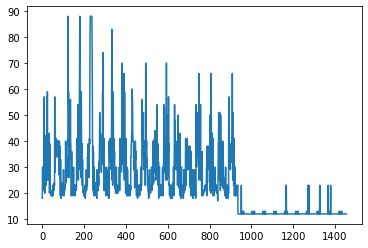

In [9]:
train_pred["prediction"].plot()

<AxesSubplot:>

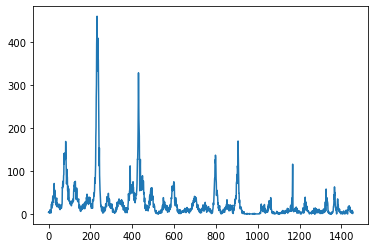

In [10]:
train_label["total_cases"].plot()